In [1]:
%matplotlib inline
# import packages
from binance.client import Client
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sklearn as skl
import pytz
import statsmodels.api as sm
from datetime import datetime, timedelta
#import zipline
import pathlib


# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")
CSV_PATH_PREFIX = os.environ.get("PATH_TO_PROJECT")

## Preliminaries: import data and visualise

In [2]:
# import data
df_hourly = {}
for key in os.listdir('hourly'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_hourly[key[:-4]] = pd.read_csv('hourly/' + key)
    df_hourly[key[:-4]]['date'] = pd.to_datetime(df_hourly[key[:-4]]['date'])# ,unit='ms')
    df_hourly[key[:-4]].set_index('date', inplace=True)

BCHUSDT
BNBUSDT
BTCUSDT
ETHUSDT
XRPUSDT


In [3]:
# import data, far more minute data but quality is questionable
df_minutely = {}
for key in os.listdir('minute'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_minutely[key[:-4]] = pd.read_csv('minute/' + key)
    df_minutely[key[:-4]]['date'] = pd.to_datetime(df_minutely[key[:-4]]['date'])# ,unit='ms')
    df_minutely[key[:-4]].set_index('date', inplace=True)

BCHUSDT
BNBUSDT
BTCUSDT
ETHUSDT
XRPUSDT


In [4]:
for key in df_minutely:
    df_minutely[key].fillna(method="ffill", inplace=True)

In [5]:
#choose hourly data to analyze
df = df_hourly
# df = df_minutely

C:\Users\3731545\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


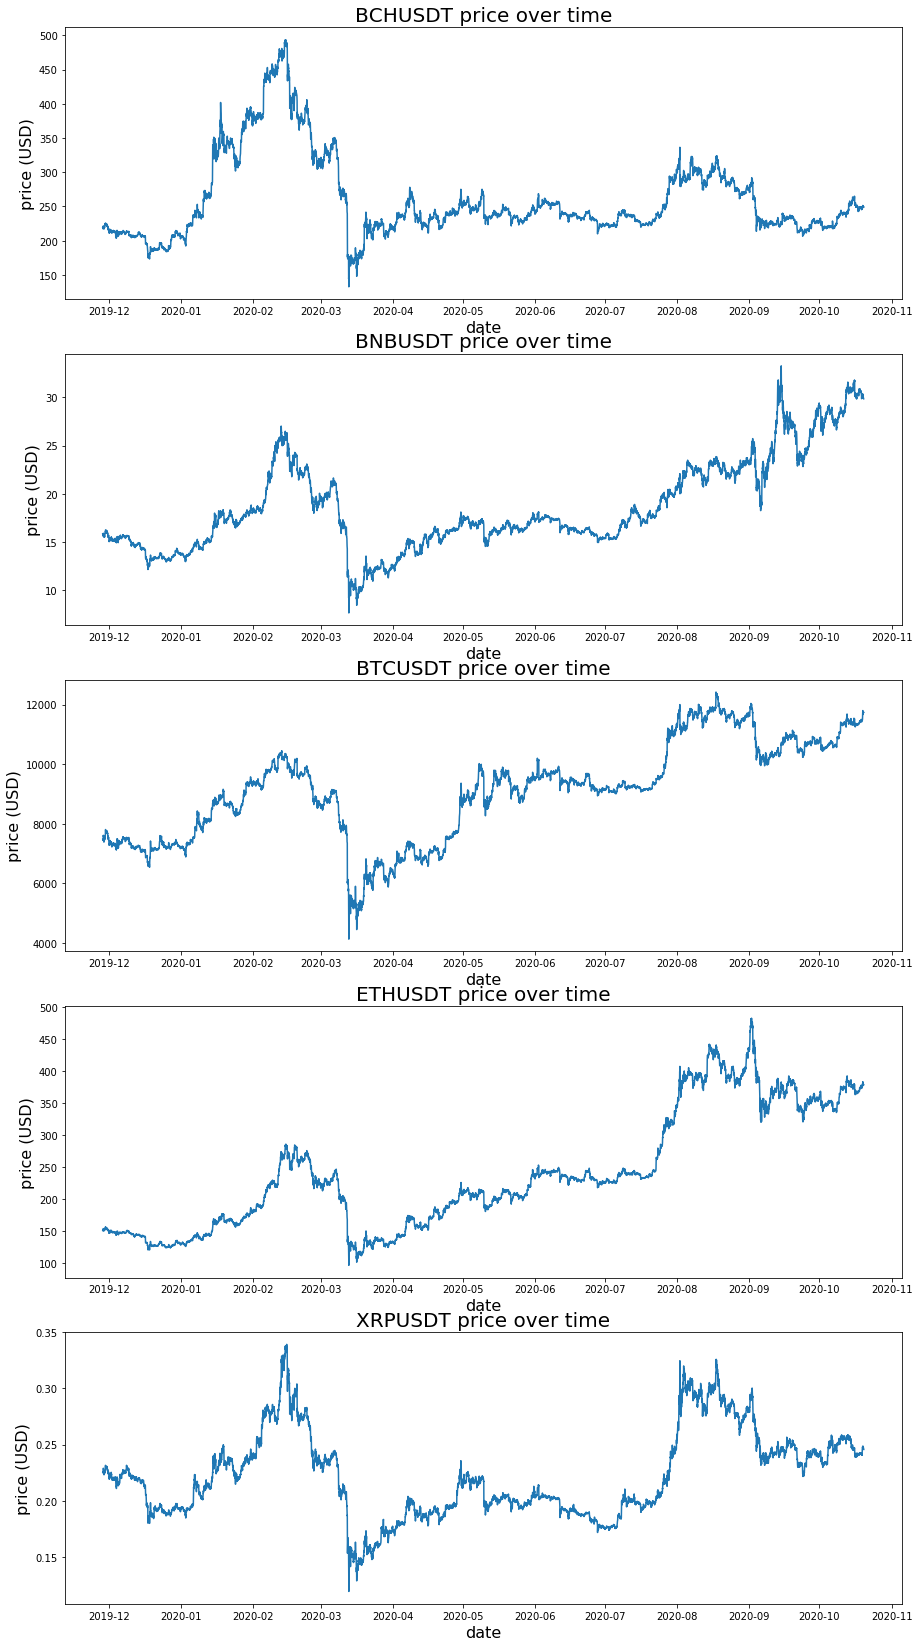

In [6]:
fig, ax = plt.subplots(len(df),figsize=(15, 29))

for i in range(len(df)):
    ax[i].plot(df[list(df.keys())[i]]['close']) # stacked plot of each of the currencies
    ax[i].set_title(list(df.keys())[i] + ' price over time',fontsize = 20) # set plot titles
    

# set axes lab%matplotlib inlineels
for i in range(len(df)):
    ax[i].set_xlabel('date',fontsize=16)
    ax[i].set_ylabel('price (USD)', fontsize=16)

## Calculate momentum measure and rank

In [7]:
# select close price for each crypto and calculate the momentume measure to for ranking purpose
df_cor = pd.DataFrame()
for key in df:
    #print(key)
    df_cor[key] = df[key]['close']

In [8]:
#follow Clenow (2015) to compute the momentum measure
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    var_ind = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(var_ind, returns)
    return ((1 + slope) ** 252*24) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [9]:
#apply a rolling week window momentum function to all cryptos
keys = []
for key in os.listdir('hourly'):
   keys.append(key[:-4]) 

momentums = df_cor.copy(deep=True)
for key in keys:
    momentums[key] = df_cor[key].rolling(168).apply(momentum, raw=False)

The best momentum value crypto is: BNBUSDT


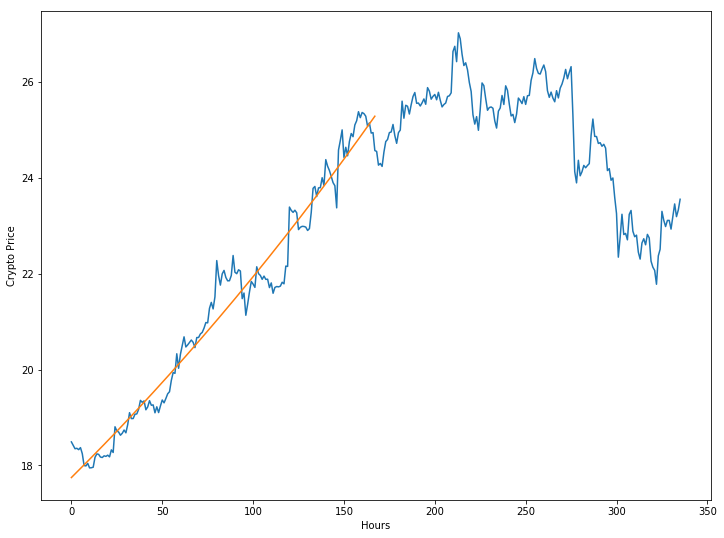

In [10]:
#Just look the best momentume values among those 5 cryptos; plot the price as well as regression curve 
plt.figure(figsize=(12, 9))
plt.xlabel('Hours')
plt.ylabel('Crypto Price')

bests = momentums.max().sort_values(ascending=False).index[:1]
print("The best momentum value crypto is: " + bests[0])
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(df_cor[best].iloc[end - 168 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(336), df_cor[best][end-168:end+168])
    plt.plot(x, np.e ** (intercept + slope*x))

## Implement momentum algorithm using support and resistence

In [11]:
# calculate correlations for closing prices of cryptocurrencies
crypto='BNBUSDT'
df_trading = pd.DataFrame()
df_trading['open_price']=df['BNBUSDT']['open']
df_trading['close_price']=df['BNBUSDT']['close']


In [12]:
#the trading strategy is based on Donadio and Ghosh (2019)
def trading_support_resistance(data, bin_width=168, margin=0.2, period=2):
    in_support=0
    in_resistance=0

    for x in range(bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['close_price'])
        resistance_level=max(data_section['close_price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + (margin * range_level)
        data['res_tolerance'][x]=resistance_level - (margin * range_level)
        
        if data['close_price'][x]>=data['res_tolerance'][x] and data['close_price'][x] <= data['res'][x]:
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['close_price'][x] <= data['sup_tolerance'][x] and data['close_price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        if in_resistance > period:
            data['signal'][x]=1
        elif in_support > period:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
            
        data['positions']=data['signal'].diff()

In [13]:
# Specify the parameters for the trading strategy
window_width = 72
zone_margin = 0.2
waiting_period = 2

start_date = datetime(2019, 11, 28)
print("Starting date:", start_date)
#end_date = datetime.now()
end_date = datetime(2020, 10, 20)
print("Ending date:", end_date)

initial_capital = 10000.00

Starting date: 2019-11-28 00:00:00
Ending date: 2020-10-20 00:00:00


In [14]:
df_trading['sup_tolerance'] = np.zeros(len(df_trading))
df_trading['res_tolerance'] = np.zeros(len(df_trading))
df_trading['sup_count'] = np.zeros(len(df_trading))
df_trading['res_count'] = np.zeros(len(df_trading))
df_trading['sup'] = np.zeros(len(df_trading))
df_trading['res'] = np.zeros(len(df_trading))
df_trading['signal'] = np.zeros(len(df_trading))
df_trading['positions'] = np.zeros(len(df_trading))

trading_support_resistance(df_trading, window_width, zone_margin, waiting_period)

# List the Buy signals
#df_trading[df_trading.positions == 1.0]

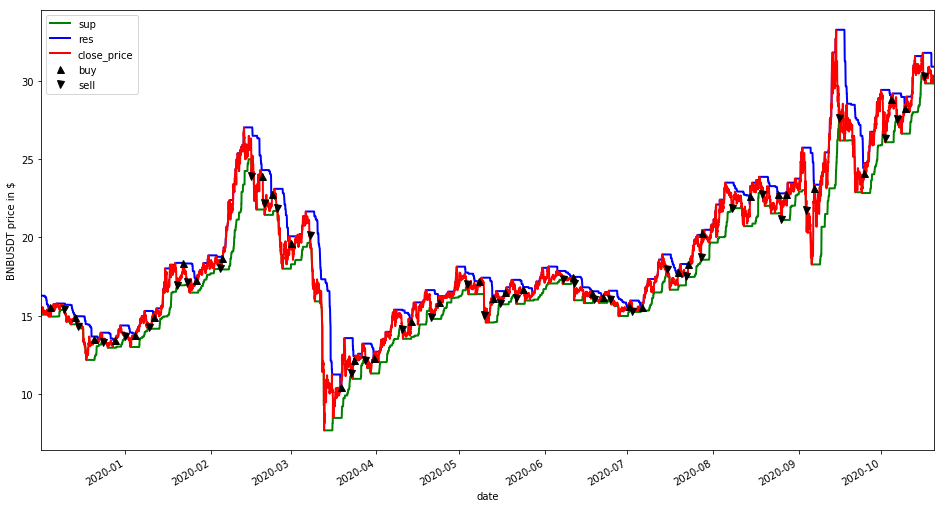

In [15]:
graph_data = df_trading[window_width:]
fig = plt.figure(figsize=(16,9))
ylabel = crypto + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel)
graph_data['sup'].plot(ax=ax1, color='g', lw=2.)
graph_data['res'].plot(ax=ax1, color='b', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(graph_data.loc[graph_data.positions == 1.0].index, graph_data.close_price[graph_data.positions == 1.0], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.positions == -1.0].index, graph_data.close_price[graph_data.positions == -1.0], 'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

In [16]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=df_trading.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['gain_loss'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital

# The conditional parameters below determine how the trading strategy will be carried out
for i in range(1, len(portfolio)):
    if ((df_trading.iloc[i]['positions'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0)):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']*math.floor(portfolio.iloc[i-1]['cash_onhand']/df_trading.iloc[i]['open_price'])
        portfolio.iloc[i]['cost_basis'] = df_trading.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']*math.floor(portfolio.iloc[i-1]['cash_onhand']/df_trading.iloc[i]['open_price'])
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
        recent_cost = df_trading.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']*math.floor(portfolio.iloc[i-1]['cash_onhand']/df_trading.iloc[i]['open_price'])
        print('BOUGHT QTY:', portfolio.iloc[i]['qty_onhand'], 'on', portfolio.index[i], 'at the price of', df_trading.iloc[i]['open_price'])
    elif ((not df_trading.iloc[i]['positions'] == 0) and (portfolio.iloc[i-1]['qty_onhand'] > 0)):
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']*portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = df_trading.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']*portfolio.iloc[i-1]['qty_onhand'] * -1
        portfolio.iloc[i]['gain_loss'] = (recent_cost + (df_trading.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']*portfolio.iloc[i-1]['qty_onhand'])) * -1
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
        recent_cost = 0.00
        print('SOLD QTY:', portfolio.iloc[i-1]['qty_onhand'], 'on', portfolio.index[i], 'at the price of', df_trading.iloc[i]['open_price'])
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = df_trading.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital


BOUGHT QTY: 646 on 2019-12-04 15:00:00 at the price of 15.4688
SOLD QTY: 646 on 2019-12-09 17:00:00 at the price of 15.38
BOUGHT QTY: 664 on 2019-12-13 17:00:00 at the price of 14.9638
SOLD QTY: 664 on 2019-12-14 17:00:00 at the price of 14.2767
BOUGHT QTY: 704 on 2019-12-20 12:00:00 at the price of 13.463
SOLD QTY: 704 on 2019-12-23 23:00:00 at the price of 13.2536
BOUGHT QTY: 693 on 2019-12-28 02:00:00 at the price of 13.459000000000001
SOLD QTY: 693 on 2019-12-31 19:00:00 at the price of 13.6905
BOUGHT QTY: 692 on 2020-01-04 08:00:00 at the price of 13.7239
SOLD QTY: 692 on 2020-01-09 16:00:00 at the price of 14.4478
BOUGHT QTY: 671 on 2020-01-11 08:00:00 at the price of 14.8919
SOLD QTY: 671 on 2020-01-19 14:00:00 at the price of 16.9782
BOUGHT QTY: 624 on 2020-01-22 01:00:00 at the price of 18.2607
SOLD QTY: 624 on 2020-01-23 11:00:00 at the price of 17.086
BOUGHT QTY: 617 on 2020-01-26 12:00:00 at the price of 17.278
SOLD QTY: 617 on 2020-02-04 11:00:00 at the price of 17.984
BOU

In [17]:
portfolio.head()

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
date,,,,,,,,,
2019-11-28 10:00:00,0,0,0,0,0,10000,0,10000,0
2019-11-28 11:00:00,0,0,0,0,0,10000,0,10000,0
2019-11-28 12:00:00,0,0,0,0,0,10000,0,10000,0
2019-11-28 13:00:00,0,0,0,0,0,10000,0,10000,0
2019-11-28 14:00:00,0,0,0,0,0,10000,0,10000,0


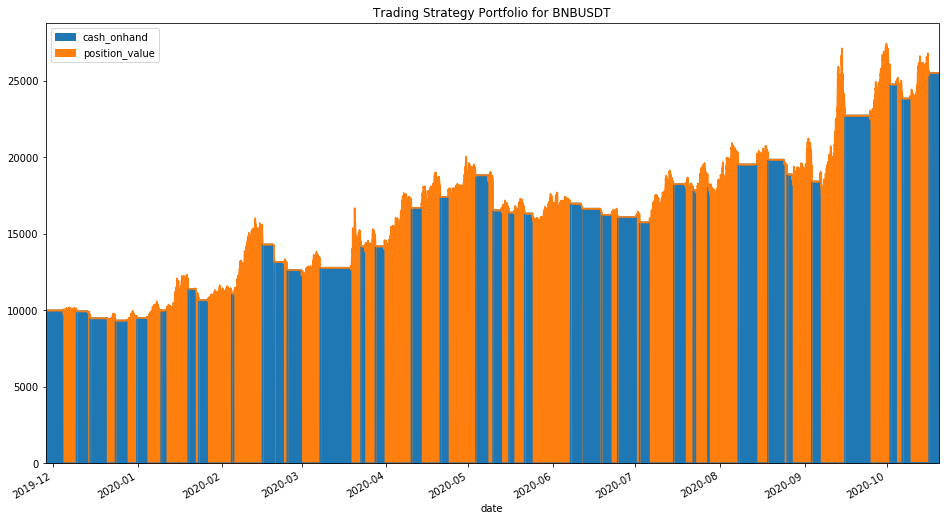

In [18]:
title_string = 'Trading Strategy Portfolio for ' + crypto
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [19]:
# Construct a long only as a benchmark for the trading strategy
benchmark = pd.DataFrame(index=df_trading.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']*math.floor(initial_capital/df_trading.iloc[0]['open_price'])
benchmark.iloc[0]['cash_onhand'] = initial_capital - (df_trading.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action']*math.floor(initial_capital/df_trading.iloc[0]['open_price']))
benchmark.iloc[0]['position_value'] = df_trading.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = df_trading.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

#benchmark.head(10)

In [20]:
# Build a performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=df_trading.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.tail(10)

,strategy,benchmark
date,,
2020-10-19 15:00:00,15513.8,9030.62
2020-10-19 16:00:00,15513.8,8958.51
2020-10-19 17:00:00,15513.8,8906.35
2020-10-19 18:00:00,15513.8,8846.22
2020-10-19 19:00:00,15513.8,8851.61
2020-10-19 20:00:00,15513.8,8810.79
2020-10-19 21:00:00,15513.8,8776.24
2020-10-19 22:00:00,15513.8,8771.17
2020-10-19 23:00:00,15513.8,8757


In [21]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 155.14 percent
The accumulated return/loss from the long-only benchmark: 87.22 percent


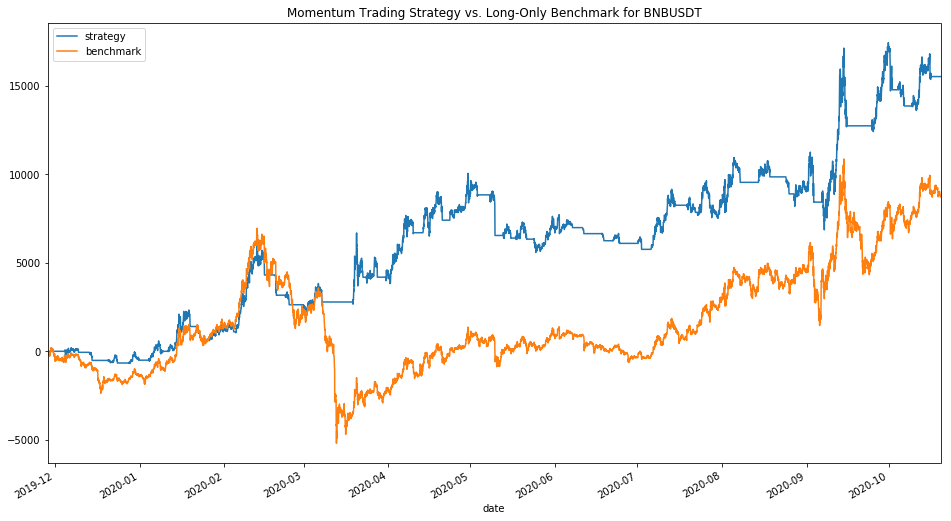

In [22]:
title_string = 'Momentum Trading Strategy vs. Long-Only Benchmark for ' + crypto
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()